## Courtesy Of
[A sample for public purpose](https://nih.go.kr/ko/main/contents.do?menuNo=300567)

## Import Libraries

In [30]:
import os
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from matplotlib.font_manager import fontManager, FontProperties

fontPath="https://raw.githubusercontent.com/orioncactus/pretendard/main/packages/pretendard/dist/public/static/alternative/Pretendard-Regular.ttf"
fontFile=Path("./res/Pretendard.ttf")

if not os.path.exists(fontFile):
  res=requests.get(fontPath)
  fontFile.write_bytes(res.content)

fontManager.addfont(fontFile)
fontProperty=FontProperties(fname=fontFile)
sns.set(font=fontProperty.get_name())

padding="ㅡ"*10
res="./res"

_spec_type_dict={
    "연속형":"contiguous",
    "범주형":"sparse",
    "날짜":"date",
    "ID":"idx",
    "#":None
}

_spec_column_list=[
    "seq",
    "table",
    "table_",
    "variable",
    "variableInfo",
    "variableValue",
    "variableType",
    "variableView"
]

_uk_dict={
    66666:np.nan,
    77777:np.nan,
    99999:np.nan
}

_indices=["id","date","visit","data_class"]

_feather_write_option=dict(
  compression="zstd",
  compression_level=9
)


## Preprocess Dataset Specification (code-book)

In [49]:
if not os.path.exists(os.path.join(res,"koges-spec.feather")):
    _spec=[q.path for q in os.scandir(res) if q.name.endswith(".xlsx")]
    koges_spec=pd.concat([pd.read_excel(q,skiprows=2).set_axis(_spec_column_list,axis=1) for q in _spec],axis=0).drop("seq",axis=1)
    koges_spec=koges_spec.map(
        lambda q:"#" if pd.isna(q) else q
    )
    koges_spec.loc[:,"variable"]=koges_spec.variable.map(
        lambda q:q[q.find("_")+1:].strip().lower()
    )
    koges_spec.loc[:,"variableInfo"]=koges_spec.variableInfo.map(
        lambda q:q.replace("\n","_").strip()
    )
    koges_spec.loc[:,"variableType"]=list(map(
        lambda q:_spec_type_dict[q],koges_spec.variableType
    ))
    koges_spec.loc[:,"variableInfo"]=koges_spec.variableInfo.apply(
        lambda q:q.replace("_",": ").replace("- ",": ").replace(": : ",": ").strip()
    )

    def koges_spec_variableValue_sanitise(x:str):
        '''An adhoc function to removing lineseps'''
        x=x.strip()
        if x.startswith("\n"):
            x=x[2:]
        if x.endswith("\n"):
            x=x[:-3]
        if x.__contains__("\n"):
            x=x.replace("\n",", ")
        return x
    
    koges_spec.loc[:,"variableValue"]=koges_spec.variableValue.map(
        koges_spec_variableValue_sanitise
    )
    koges_spec.index=range(koges_spec.shape[0])
    koges_spec.to_feather(os.path.join(res,"koges-spec.feather"),**_feather_write_option)

else:
    print(padding,"Found a sanitised spec file")
    koges_spec=pd.read_feather(os.path.join(res,"koges-spec.feather"))

koges_spec[koges_spec.variableType=="sparse"].sample(5)

C:\Users\yuninze\AppData\Local\Temp\ipykernel_5980\4220614431.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  koges_spec=koges_spec.applymap(


,table,table_,variable,variableInfo,variableValue,variableType,variableView
174,FOLLOW_05_DATA,생활습관,drink,음주여부,"1=예(비음주), 2=아니오(과거음주), 3= 아니오(현재음주)",sparse,\n■ 귀하는 원래 술을 못 마시거나 또는 처음부터(종교적인 이유 등으로) 술을 안...
128,FOLLOW_03_DATA,생활습관,beerfq,맥주 음주빈도,"0=없다, 1=월1회, 2=월 2-3회, 3=주 1회, 4=주2-3회, 5=주4-6...",sparse,\n 5-a) 맥주를 1년 동안 드신 평균횟수는?\n ...
196,FOLLOW_05_DATA,과거력,lip,고지혈증 진단 여부,"1=아니오, 2=예",sparse,\n ▶ 고지혈증 진단 여부\n ① 아니오\n ...
14,BASE_DATA2,가족력,fmfht2,고혈압 진단여부(모),"1=아니오, 2=예",sparse,\n ▶ 고혈압 진단 여부(모)\n ① 아니오\n ...
192,FOLLOW_05_DATA,과거력,htn,고혈압 진단 여부,"1=아니오, 2=예",sparse,\n■ 귀하는 병·의원에서 의사로부터 아래의 질병으로 진단받은 적이 있습니까?\n\...


## Preprocess Dataset

In [38]:
_data={q.name.split(".")[0]:pd.read_csv(q.path) for q in os.scandir(res) if q.name.lower().startswith("follow")}
for d in _data:
    _data[d]=_data[d].set_axis([q[q.index("_")+1:].lower() for q in _data[d].columns],axis=1).rename(columns={"edate":"date"}).assign(visit=d)
    _data[d].loc[:,"id"]=_data[d].id.map(lambda q:str(q[q.rfind("_")+1:]))
koges=pd.concat(_data.values()).convert_dtypes().set_index(_indices).sort_index()
koges.iloc[:5]

sex  age   edu  marry  drink  drdu  \
id   date   visit          data_class                                        
0001 200412 FOLLOW_01_DATA F05            1   56     1      2      3     4   
     200909 FOLLOW_03_DATA F05         <NA>   61  <NA>      2      2  <NA>   
     201208 FOLLOW_04_DATA F05         <NA>   64  <NA>      2      2  <NA>   
0002 200401 FOLLOW_01_DATA F19            1   40     3      2      3     4   
     200810 FOLLOW_03_DATA F19         <NA>   44  <NA>      2      3  <NA>   

                                       takfq    takam  ricefq   riceam  ...  \
id   date   visit          data_class                                   ...   
0001 200412 FOLLOW_01_DATA F05             0  77777.0       0  77777.0  ...   
     200909 FOLLOW_03_DATA F05             0  77777.0       0  77777.0  ...   
     201208 FOLLOW_04_DATA F05             0  77777.0       0  77777.0  ...   
0002 200401 FOLLOW_01_DATA F19             0  77777.0       0  77777.0  ...   
     200810 FOLLOW_03_DATA F19             0  77777.0       0  77777.0  ...   

                                       dbp  hba1c   glu0  creatinine  ast  \
id   date   visit          data_class                                       
0001 200412 FOLLOW_01_DATA F05          80    5.6     82         0.7   30   
     200909 FOLLOW_03_DATA F05          69    5.8     96         0.9   18   
     201208 FOLLOW_04_DATA F05          70    5.9     92         1.1   24   
0002 200401 FOLLOW_01_DATA F19         118    5.5    130         1.1   46   
     200810 FOLLOW_03_DATA F19          82    5.5  99999         1.0   31   

                                       alt  tchl  hdl   tg     ins0  
id   date   visit          data_class                                
0001 200412 FOLLOW_01_DATA F05          38   154   35  126      6.7  
     200909 FOLLOW_03_DATA F05          14   190   35  111     12.0  
     201208 FOLLOW_04_DATA F05          29   179   28  139      6.5  
0002 200401 FOLLOW_01_DATA F19          75   214   44  169      4.3  
     200810 FOLLOW_03_DATA F19          33   147   39  320  99999.0  

[5 rows x 61 columns]

## Take a Look

In [40]:
koges_agg=koges.select_dtypes("number").agg(["mean","median","max","min",lambda q:q.isna().sum(),"count"]).T
koges_agg.sample(5)

,mean,median,max,min,<lambda>,count
hliqfq,771.422511,0.0,99999.0,0.0,0.0,2852.0
drdu,41478.984000,77777.0,99999.0,1.0,1852.0,1000.0
ricefq,771.406732,0.0,99999.0,0.0,0.0,2852.0
height,369.256311,159.0,99999.0,133.0,0.0,2852.0
ins0,20307.059257,9.0,99999.0,0.2,0.0,2852.0


In [41]:
koges_agg.loc[koges_agg["<lambda>"]>0]

,mean,median,max,min,<lambda>,count
sex,1.558,2.0,2.0,1.0,1852.0,1000.0
edu,702.283,2.0,99999.0,1.0,1852.0,1000.0
drdu,41478.984,77777.0,99999.0,1.0,1852.0,1000.0
smag,51251.670,77777.0,99999.0,12.0,1852.0,1000.0
mnsag,34886.254,18.0,99999.0,11.0,1852.0,1000.0
preg,34478.539,2.0,99999.0,1.0,1852.0,1000.0
fpregag,35312.563,28.0,99999.0,16.0,1852.0,1000.0
child,35100.519,2.0,99999.0,1.0,1852.0,1000.0
flabag,35546.167,29.0,99999.0,17.0,1852.0,1000.0


In [59]:
column_info=dict([q for q in koges_spec.loc[:,["variable","variableInfo"]].itertuples(index=False)])

In [60]:
def explain(column_list:list)->list:
  return list(map(lambda q:column_info[q] if q in column_info else q,column_list))

## Forward Filling by the 1st Observation
Assume 0-th rows in the id groups are the first visit

In [65]:
fflo=koges.reset_index().groupby("id")
fflo=fflo.nth(0).notna().all() & fflo.nth(1).isna().any()
fflo_column=fflo[fflo].index.tolist()

In [66]:
dict(zip(
  fflo_column,
  explain(fflo_column)
))

{'sex': '성별',
 'edu': 'edu',
 'drdu': '지금까지 총 음주기간',
 'smag': 'smag',
 'mnsag': '초경나이',
 'preg': '임신 경험 여부',
 'fpregag': '첫 임신시 나이',
 'child': 'child',
 'flabag': 'flabag'}

In [68]:
koges.sort_index(level=(0,1)).groupby("id")[fflo_column].ffill().iloc[:6]

sex  edu  drdu  smag  mnsag   preg  \
id   date   visit          data_class                                       
0001 200412 FOLLOW_01_DATA F05           1    1     4    20  77777  77777   
     200909 FOLLOW_03_DATA F05           1    1     4    20  77777  77777   
     201208 FOLLOW_04_DATA F05           1    1     4    20  77777  77777   
0002 200401 FOLLOW_01_DATA F19           1    3     4    20  77777  77777   
     200810 FOLLOW_03_DATA F19           1    3     4    20  77777  77777   
     201110 FOLLOW_04_DATA F19           1    3     4    20  77777  77777   

                                       fpregag  child  flabag  
id   date   visit          data_class                          
0001 200412 FOLLOW_01_DATA F05           77777  77777   77777  
     200909 FOLLOW_03_DATA F05           77777  77777   77777  
     201208 FOLLOW_04_DATA F05           77777  77777   77777  
0002 200401 FOLLOW_01_DATA F19           77777  77777   77777  
     200810 FOLLOW_03_DATA F19           77777  77777   77777  
     201110 FOLLOW_04_DATA F19           77777  77777   77777

In [71]:
koges.loc[:,fflo_column]=koges.sort_index(level=(0,1)).groupby("id")[fflo_column].ffill()

In [72]:
if len(koges.columns.tolist()) == len(set(koges.columns.tolist())):print(padding)

ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ


## Fill Contextual Missing (Feamle-only Columns)
As aboves are very likely female-only values of age

In [75]:
feamle_only_column=fflo_column[3:]
koges.groupby("sex")[feamle_only_column].value_counts()

sex  smag   mnsag  preg   fpregag  child  flabag
1    77777  77777  77777  77777    77777  77777     233
     20     77777  77777  77777    77777  77777     232
     19     77777  77777  77777    77777  77777     122
     18     77777  77777  77777    77777  77777      96
     21     77777  77777  77777    77777  77777      84
                                                   ... 
2    77777  20     2      21       2      21          2
                          23       1      23          2
                          25       2      26          2
            99999  2      20       1      21          2
                          27       1      27          2
Name: count, Length: 361, dtype: int64

In [78]:
koges.loc[koges.sex<2,
  [q for q in feamle_only_column if q.endswith("ag")]
]=100
koges.loc[koges.sex<2,
  [q for q in feamle_only_column if not q.endswith("ag")]
]=-1

In [79]:
koges.groupby("sex")[feamle_only_column].value_counts()

sex  smag   mnsag  preg  fpregag  child  flabag
1    100    100    -1    100      -1     100       1266
2    77777  14     2     23       2      24          20
            16     2     24       2      25          20
            17     2     23       2      23          20
            15     2     21       1      22          18
                                                   ... 
            20     2     21       2      21           2
                         23       1      23           2
                         25       2      26           2
            99999  2     20       1      21           2
                         27       1      27           2
Name: count, Length: 331, dtype: int64

## Scale Visit Date

In [88]:
_date=np.asarray([f"{str(q)[:4]}-{str(q)[-2:]}" for q in koges.index.get_level_values(1).unique()],dtype="M")
_date_min=np.min(_date)
_date_max=np.max(_date)
_date_difference=np.abs(_date_min-_date_max)
_scale_date=lambda q:(q-_date_min)/_date_difference

In [89]:
_parse_date=lambda q:f"{str(q)[:4]}-{str(q)[-2:]}"

_date_scale_dict=dict(zip(
  _date.astype(dtype=str),
  np.asarray([_scale_date(q) for q in _date],dtype=np.float32)
))

_date_scale_dict

{np.str_('2004-12'): np.float32(0.16197184),
 np.str_('2009-09'): np.float32(0.5633803),
 np.str_('2012-08'): np.float32(0.80985916),
 np.str_('2004-01'): np.float32(0.08450704),
 np.str_('2008-10'): np.float32(0.48591548),
 np.str_('2011-10'): np.float32(0.7394366),
 np.str_('2003-09'): np.float32(0.056338027),
 np.str_('2008-06'): np.float32(0.45774648),
 np.str_('2011-06'): np.float32(0.7112676),
 np.str_('2005-04'): np.float32(0.19014084),
 np.str_('2010-05'): np.float32(0.6197183),
 np.str_('2013-04'): np.float32(0.86619717),
 np.str_('2004-02'): np.float32(0.09154929),
 np.str_('2009-01'): np.float32(0.5070422),
 np.str_('2011-11'): np.float32(0.74647886),
 np.str_('2012-10'): np.float32(0.8239437),
 np.str_('2004-10'): np.float32(0.14788732),
 np.str_('2012-11'): np.float32(0.8309859),
 np.str_('2003-08'): np.float32(0.049295776),
 np.str_('2009-07'): np.float32(0.5492958),
 np.str_('2012-07'): np.float32(0.8028169),
 np.str_('2003-01'): np.float32(0.0),
 np.str_('2007-10'): np.

In [100]:
koges=koges.assign(theta=list(map(
  lambda q:_date_scale_dict[_parse_date(q)],koges.index.get_level_values(1)
)))
koges.sample(5)


,,,,sex,age,edu,marry,drink,drdu,takfq,takam,ricefq,riceam,...,hba1c,glu0,creatinine,ast,alt,tchl,hdl,tg,ins0,theta
id,date,visit,data_class,,,,,,,,,,,,,,,,,,,,,
0259,201311,FOLLOW_04_DATA,F05,2,66,2,2,1,77777,0,77777.0,0,77777.0,...,6.1,86,0.8,18,14,177,40,118,6.7,0.915493
0580,201111,FOLLOW_04_DATA,F19,1,52,3,2,3,4,0,77777.0,0,77777.0,...,5.9,106,1.0,31,25,174,34,188,6.3,0.746479
0016,200805,FOLLOW_03_DATA,F19,2,47,3,2,2,77777,0,77777.0,0,77777.0,...,4.8,89,0.9,29,27,207,66,85,7.2,0.450704
0150,201010,FOLLOW_03_DATA,F19,2,52,3,2,1,77777,0,77777.0,0,77777.0,...,5.5,84,0.8,15,13,228,58,122,6.5,0.654930
0882,201010,FOLLOW_04_DATA,F19,1,48,4,2,3,4,0,77777.0,0,77777.0,...,5.7,113,0.9,30,32,159,40,166,10.8,0.654930


## Impute Contiguous Variables
We'll call those as contiguous rather than continuous

In [28]:
def varSelectorType(variableType:str)->list:
  final=[q for q in np.unique(
    koges_spec.loc[koges_spec.variableType==variableType,"variable"].values
    ) if q in koges.columns and q!="DATA_CLASS"
  ]
  return final

In [29]:
gaseol_y="DBP"
yesi="SBP"

In [30]:
koges_impute=koges.map(lambda q:_uk_dict[q] if q in _uk_dict else q)
koges_impute=koges_impute.loc[pd.notna(koges_impute[gaseol_y]),:]

In [31]:
imputationTargets=something

In [32]:
i0=imputationTargets[[q for q in imputationTargets.columns if not q==gaseol_y]]
o0=imputationTargets[gaseol_y]
print(f"{o0.name}")

DBP


<Axes: xlabel='SBP', ylabel='Count'>

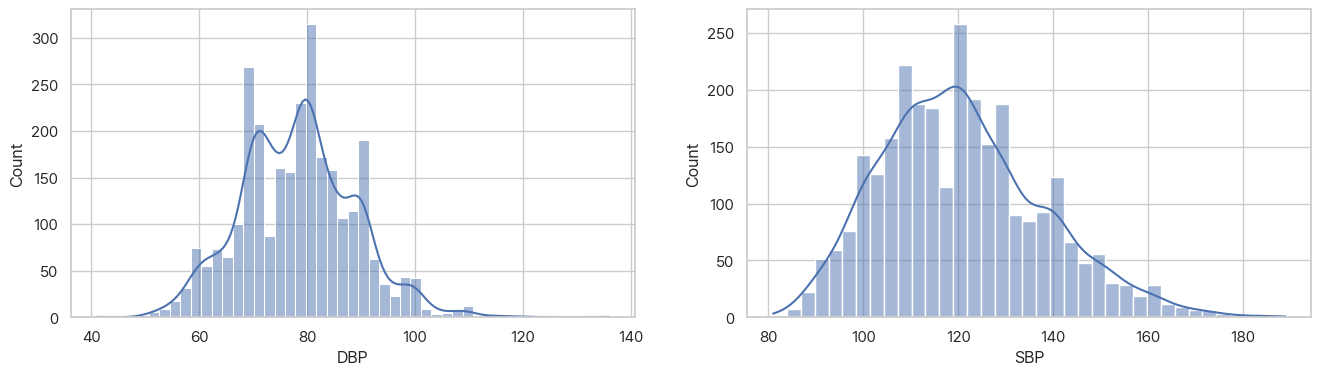

In [33]:
_,ax=plt.subplots(1,2,figsize=(16,4))
sns.histplot(o0,ax=ax[0],kde=True,legend=False)
sns.histplot(i0[yesi],ax=ax[1],kde=True,legend=False)

In [34]:
xy=pd.concat([i0,o0],axis=1)
xy.reset_index().to_feather("./res/xy.f")
print(f"{xy.shape=}")

xy.shape=(2850, 62)


In [184]:
xy

,,,theta,SEX,AGE,EDU,MARRY,DRINK,DRDU,TAKFQ,TAKAM,RICEFQ,...,HBA1C,GLU0,CREATININE,AST,ALT,TCHL,HDL,TG,INS0,DBP
id,visit,DATA_CLASS,,,,,,,,,,,,,,,,,,,,,
K_FOLLOW_0001,FOLLOW_01_DATA,F05,0.161972,1.0,56.0,1.0,2.0,3.0,4.0,0.0,NaN,0.0,...,5.6,82.0,0.7,30.0,38.0,154.0,35.0,126.0,6.7,80.0
K_FOLLOW_0002,FOLLOW_01_DATA,F19,0.084507,1.0,40.0,3.0,2.0,3.0,4.0,0.0,NaN,0.0,...,5.5,130.0,1.1,46.0,75.0,214.0,44.0,169.0,4.3,118.0
K_FOLLOW_0003,FOLLOW_01_DATA,F05,0.056338,1.0,52.0,2.0,2.0,2.0,3.0,0.0,NaN,0.0,...,5.2,83.0,0.9,29.0,45.0,130.0,27.0,134.0,7.9,90.0
K_FOLLOW_0004,FOLLOW_01_DATA,F05,0.190141,2.0,60.0,2.0,2.0,1.0,NaN,0.0,NaN,0.0,...,5.6,89.0,0.6,35.0,34.0,182.0,47.0,123.0,12.6,90.0
K_FOLLOW_0005,FOLLOW_01_DATA,F19,0.091549,1.0,49.0,3.0,2.0,3.0,4.0,0.0,NaN,0.0,...,6.9,95.0,1.0,52.0,33.0,203.0,36.0,277.0,2.7,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
K_FOLLOW_0996,FOLLOW_03_DATA,F05,0.626761,1.0,69.0,1.0,2.0,1.0,NaN,0.0,NaN,0.0,...,5.6,90.0,1.2,30.0,22.0,184.0,40.0,152.0,2.8,90.0
K_FOLLOW_0997,FOLLOW_03_DATA,F18,0.563380,1.0,68.0,3.0,2.0,3.0,2.0,1.0,1.0,0.0,...,NaN,90.0,1.0,20.0,16.0,154.0,46.0,80.0,NaN,70.0
K_FOLLOW_0998,FOLLOW_03_DATA,F19,0.478873,1.0,46.0,5.0,2.0,3.0,4.0,0.0,NaN,0.0,...,5.2,88.0,0.9,24.0,15.0,220.0,40.0,70.0,7.0,77.0


In [101]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

from sklearn.preprocessing import PowerTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

split=10**1
Splitter=ShuffleSplit(n_splits=split,random_state=23301522)

Mutater=PowerTransformer()
Estimator=RandomForestRegressor(
  random_state=23301522,
  max_features="sqrt",
  min_samples_split=int(len(set(koges.index.get_level_values(0)))*.5)
)

def make_tester_of(Imputer):
  return Pipeline(
    steps=[
      ("Yj",Mutater),
      ("An imputer",Imputer),
      ("Nan-resist regressor",Estimator)
    ],
    verbose=False
  )

def score_of(
  Tester:Pipeline,
  x,y
):
  print(Tester)
  return cross_val_score(
    Tester,
    x,y,
    scoring="neg_mean_absolute_error",
    cv=Splitter
  )


In [36]:
score_org=score_of(
  make_tester_of(SimpleImputer(strategy="constant")),i0,o0)
score_mean=score_of(
  make_tester_of(SimpleImputer(strategy="mean")),i0,o0)
score_near=score_of(
  make_tester_of(KNNImputer(add_indicator=False)),i0,o0)
score_mice=score_of(
  make_tester_of(IterativeImputer(
    min_value=0,
    sample_posterior=True,
    max_iter=100,
    tol=1e-3
  )),i0,o0)

total_score=dict(zip(
  ("Org","Mean","Near","Mice"),
  [q for q in (score_org,score_mean,score_near,score_mice)]
))

Pipeline(steps=[('Yj', PowerTransformer()),
                ('An imputer', SimpleImputer(strategy='constant')),
                ('Nan-resist regressor',
                 RandomForestRegressor(max_features='sqrt',
                                       min_samples_split=500,
                                       random_state=23301522))])


Pipeline(steps=[('Yj', PowerTransformer()), ('An imputer', SimpleImputer()),
                ('Nan-resist regressor',
                 RandomForestRegressor(max_features='sqrt',
                                       min_samples_split=500,
                                       random_state=23301522))])
Pipeline(steps=[('Yj', PowerTransformer()), ('An imputer', KNNImputer()),
                ('Nan-resist regressor',
                 RandomForestRegressor(max_features='sqrt',
                                       min_samples_split=500,
                                       random_state=23301522))])
Pipeline(steps=[('Yj', PowerTransformer()),
                ('An imputer',
                 IterativeImputer(max_iter=100, min_value=0,
                                  sample_posterior=True)),
                ('Nan-resist regressor',
                 RandomForestRegressor(max_features='sqrt',
                                       min_samples_split=500,
                                   

(-7.8, -8.1)

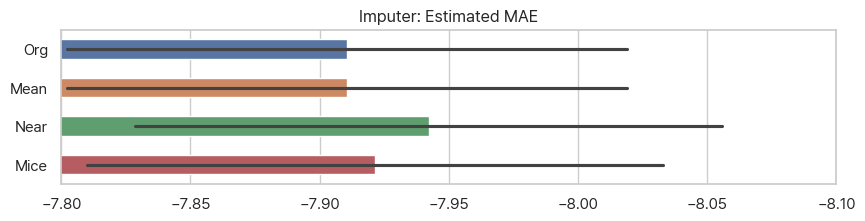

In [37]:
_,ax=plt.subplots(figsize=(10,2))
sns.barplot(total_score,errorbar="se",width=.5,orient="y").set_title("Imputer: Estimated MAE")
ax.set_xlim(-7.8,-8.1)

In [182]:
import cupy as cp
import cuml

from cuml.preprocessing import PolynomialFeatures
from cuml import IncrementalPCA

from sklearn.cluster import AgglomerativeClustering
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score

from time import time

cuml.set_global_output_type="numpy"

degree=3
Polynomials=PolynomialFeatures(degree)

def make_cluster_preprocessor():
  return Pipeline(
  steps=[
    ("Yj",Mutater),
    ("Imputer",SimpleImputer()),
    ("Polynomials",Polynomials)
  ]
)

def cluster(X,cluster_count_range=(2,30)):
  cluster_count_range:range=range(cluster_count_range[0],cluster_count_range[1]+1)
  cluster:dict={}

  for cluster_count in cluster_count_range:
    t0=time()

    Clusterer=AgglomerativeClustering(
      n_clusters=cluster_count,
      linkage="ward"
    )

    Xt=make_cluster_preprocessor().fit_transform(X)

    Clusterer.fit(Xt)

    cluster[cluster_count]=(cython_silhouette_score(
        X=cp.asarray(Xt,dtype=cp.float32),
        labels=cp.asarray(Clusterer.labels_),
        chunksize=10**5,
      ),
      Clusterer
    )

    print(f"Clustering {Xt.shape} ({Xt.nbytes/1024**2:2f}MiB), took {time()-t0:.2f}s")

  fig,ax=plt.subplots(figsize=(4,4))
  ax.plot(cluster_count_range,[q[0] for q in cluster.values()])
  ax.set_xlabel("score")
  ax.set_ylabel("n")
  ax.set_title("Silhouette Score by Number of Cluster")

  return cluster


In [183]:
cluster_result=cluster(pd.concat([i0,o0],axis=1).reset_index(drop=True).astype(np.float32))

/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Clustering (2850, 43680) (474.884033MiB), took 88.03s


/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/yuninze/conda/envs/origin/lib/python3.10/site-packages/numpy/core/_methods.py:250: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


KeyboardInterrupt: 

In [154]:
Mutater=PowerTransformer()
Imputer=SimpleImputer()
Reducer=IncrementalPCA(n_components=2,batch_size=150,output_type="numpy") # 1050MB

polynomial_reducer_processor=Pipeline([
  ("yj",Mutater),
  ("mi",Imputer),
  ("vmm",Polynomials),
  ("reducer",Reducer)
],verbose=True)

polynomial_reducer_result=polynomial_reducer_processor.fit_transform(pd.concat([i0,o0],axis=1))


[Pipeline] ................ (step 1 of 4) Processing yj, total=   0.2s
[Pipeline] ................ (step 2 of 4) Processing mi, total=   0.0s
[Pipeline] ............... (step 3 of 4) Processing vmm, total=   0.3s
[Pipeline] ........... (step 4 of 4) Processing reducer, total=   5.9s


In [156]:
label=cluster_result[5][1].labels_
{q:(label==q).sum() for q in np.unique(label)}
cluster_for_plot=np.unique(cluster_result[5][1].labels_)
cluster_for_plot

array([0, 1, 2, 3, 4])

In [180]:
sek=["xkcd:"+q for q in [
  "sea","pear","hazel","cherry","banana",
  "caramel","canary","clay","grape","iris",
  "ice","lemon"
]]

(-127.83789505268874,
 1772.9796675355446,
 -4293.058751177256,
 457.9567374747196)

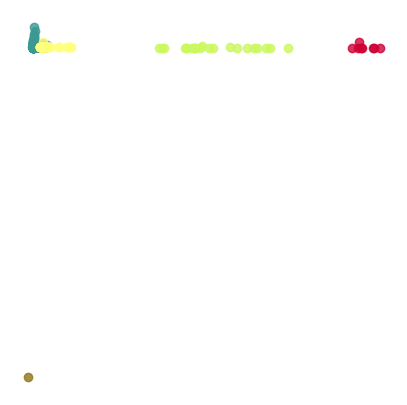

In [181]:

trimmer=np.abs(polynomial_reducer_result.sum(axis=1))<=5000
reduce_result_=polynomial_reducer_result[trimmer]

plt.subplots(figsize=(5,5))
for sek_,code_ in zip(sek,np.unique(cluster_for_plot)):
  plt.scatter(
    reduce_result_[label[trimmer]==code_,0],
    reduce_result_[label[trimmer]==code_,1],
    color=sek_,
    label=str(code_),
    alpha=.8
  )
plt.axis("off")

In [ ]:
import cupy as cp

vram=(cp.get_default_memory_pool(),cp.get_default_pinned_memory_pool())

def _freeVram(vram):
  for mp in vram:
    mp.free_all_blocks()
  return 

def meanSquaredError(prediction,answer)->cp.ndarray:
  s=cp.average(
    cp.average((prediction-answer)**2,axis=0)
  )
  return s

def crossValidate(
  estimator,
  i,
  o,
  splitter,
  scorer,
):
  _splits=splitter.split(i,o)
  
  print(f"Inputs: {i[0].shape}, {i.nbytes//1024**2} MiB")
  
  _rslt=[]
  for train_idx,test_idx in _splits:

    coef=estimator(
      i[train_idx],
      o[train_idx]
    )
    prediction=cp.dot(
      cp.asarray(i[test_idx],dtype=cp.float32),
      coef
    )
    score=scorer(
      prediction,
      cp.asarray(o[test_idx],dtype=cp.float32)
    )

    _rslt.append([cp.asnumpy(coef),cp.asnumpy(score)])
  
  estimator,
  scorer,
  i,
  o,
  coef,
  prediction,
  score=(
    None,None,None,None,None,None,None
  )
  _freeVram(vram)

  return _rslt

def squareLeast(x,y,rcond=None)->cp.ndarray:
  if x.shape[0]==y.shape[0]:
    x=cp.asarray(x,dtype=cp.float32)
    y=cp.asarray(y,dtype=cp.float32)
    coef=cp.linalg.lstsq(x,y)
    
    x,y=(None,None)
    _freeVram(vram)

    return coef[0]
  raise IndexError("Row Count Mismatch")


In [72]:
r=crossValidate(squareLeast,x_ii_polynomials,y_ii,splitter=splitter,scorer=meanSquaredError)

Inputs: (8436,), 62 MiB


/home/yuninze/conda/envs/something/lib/python3.10/site-packages/cupy/linalg/_solve.py:171: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  warnings.warn(


In [73]:
polynomialCoefs=np.asarray([q[0] for q in r],np.float32)
polynomialStds=np.std(np.stack([r[0] for r in r]),axis=0)

In [83]:
polynomialCoefMeans=np.asarray(np.mean(polynomialCoefs,axis=0),np.float32)
polynomialCoefCi=[q[0]+q[1]*2 for q in zip(polynomialCoefMeans,polynomialStds)]

(8436,)

In [91]:
polynomialNames=[q.replace(" "," * ") for q in Polynomials.get_feature_names_out(xy.iloc[:,:-1].columns)]

In [117]:
made=50
components=[(p[0],p[1],p[2]) for p in 
  zip(polynomialNames,polynomialCoefMeans,polynomialCoefCi)]
components=sorted(components,key=lambda q:np.abs(q[1]),reverse=True)
components=components[:made]

/tmp/ipykernel_4089/2577988604.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")


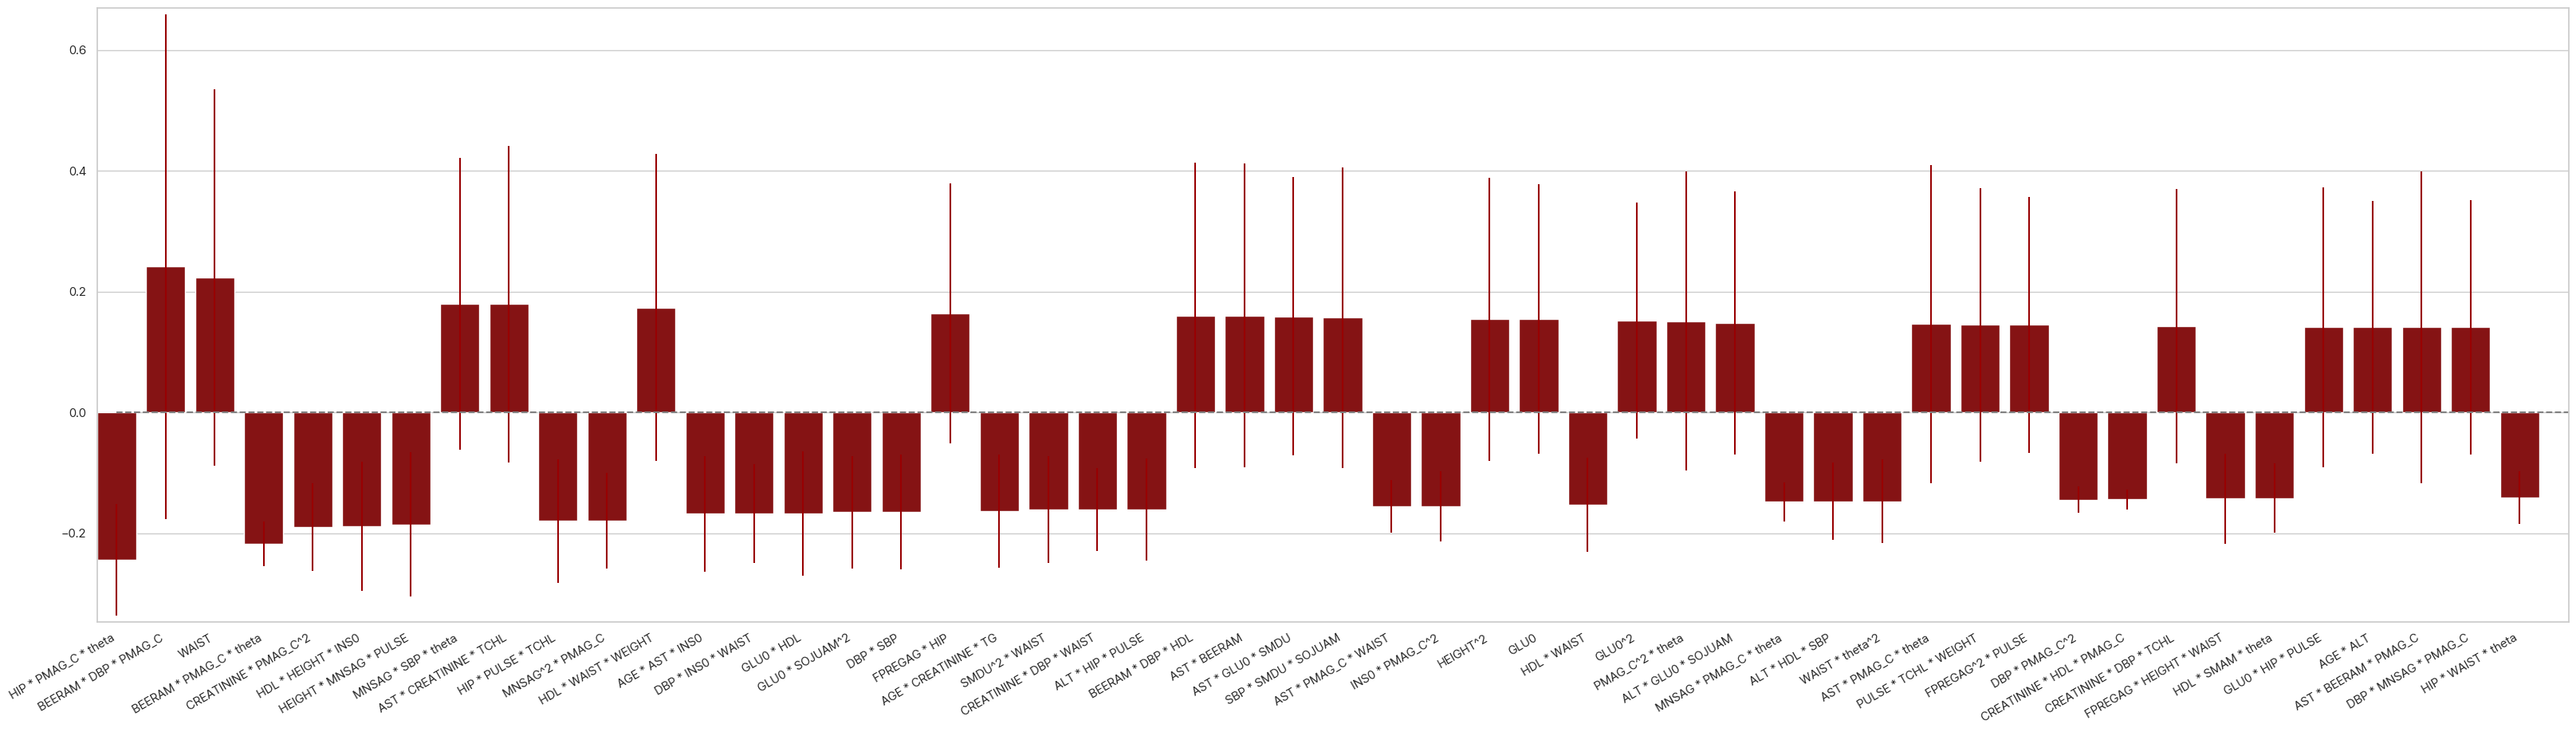

In [118]:
sek="xkcd:blood red"

fig,ax=plt.subplots(figsize=(40,10))
sns.barplot(
  dict(zip(
    [q[0] for q in components],
    [q[1] for q in components])
  ),
  ax=ax,
  color=sek,
)
plt.errorbar(
  x=range(0,made),
  y=[q[1] for q in components],
  yerr=[np.abs(q[2]) for q in components],
  fmt="none",
  c=sek
)
plt.hlines(0,0,made,colors="gray",linestyle="dashed")
plt.grid(True,"both","y")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")
ax.margins(x=0,y=.01)

In [ ]:
from sklearn.model_selection import cross_validate

Tester=Pipeline(
  [
    ("Mutater",PowerTransformer()),
    ("Imputer",SimpleImputer())
    ("Expansion",PolynomialFeatures(degree)),
    ("Regressor",cuml.LinearRegression())
  ]
)

lingress_result=cross_validate(
  Tester,
  i0,o0,
  scoring="neg_mean_absolute_error",
  cv=Splitter,
  return_estimator=True
)

In [66]:
from cuml.linear_model import Lasso
from sklearn.model_selection import cross_validate

alpha=np.logspace(-5,-.3,10**2,dtype=np.float32)

resultPerAlpha:dict={
  "alpha":[],"mse":[],"coef":[],"coefMean":[],
}

for _a in alpha:
  _crosser=cross_validate(
    Lasso(
      alpha=_a,
      fit_intercept=False,
      max_iter=10**2,
    ),
    x_ii_polynomials,
    y_ii,
    scoring="neg_mean_squared_error",
    return_estimator=True,
    verbose=4
  )

  _coef=cp.asarray(
    [c.coef_ for c in _crosser["estimator"]],
    cp.float32
  )
  _coefMean=cp.mean(_coef,axis=0)
  _mse=(cp.mean(cp.asarray(_crosser["test_score"],cp.float32))*-1)
  
  resultPerAlpha["alpha"].append(_a)
  resultPerAlpha["coef"].append(_coef.get())
  resultPerAlpha["coefMean"].append(_coefMean.get())
  resultPerAlpha["mse"].append(_mse.get())
  
  _crosser,_coef,_coefMean,_mse=(None,None,None,None)
  _freeVram(vram)


[CV] END ......................................, score=-4.429 total time=  13.4s
[CV] END ......................................, score=-4.593 total time=  13.8s
[CV] END ......................................, score=-4.091 total time=  13.6s
[CV] END ......................................, score=-3.275 total time=  13.7s
[CV] END ....................................., score=-28.402 total time=  13.1s
[CV] END ......................................, score=-4.396 total time=  13.1s
[CV] END ......................................, score=-4.514 total time=  13.2s
[CV] END ......................................, score=-4.084 total time=  13.1s
[CV] END ......................................, score=-3.278 total time=  13.1s
[CV] END ....................................., score=-18.852 total time=  13.0s
[CV] END ......................................, score=-4.364 total time=  13.2s
[CV] END ......................................, score=-4.451 total time=  13.5s
[CV] END ...................

KeyboardInterrupt: 

Text(0, 0.5, 'MSE')

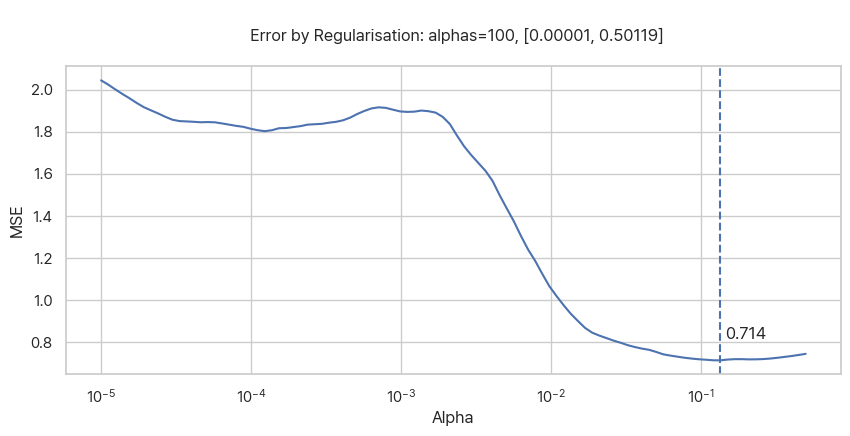

In [ ]:
fig,ax=plt.subplots(figsize=(10,4))

ax.set_title(f"""
  MSE by Regularisation: alphas={len(alpha)}, [{alpha[0]:.5f}, {alpha[-1]:.5f}]
""")

plt.plot(resultPerAlpha["alpha"],resultPerAlpha["mse"])

alphaMin=np.min(resultPerAlpha["mse"])
alphaAtLowestMse=resultPerAlpha["alpha"][np.argmin(resultPerAlpha["mse"])]

plt.axvline(alphaAtLowestMse,linestyle="dashed")
plt.annotate(f"{alphaMin:.3f}",(alphaAtLowestMse+.01,alphaMin+.1))

ax.set_xscale("log")
plt.xlabel("Alpha")
plt.ylabel("MSE")